# roAp Classification using A.I.
### Not using regressions, like in CS 455 project; using vectorization to classify groupings in the cluster. 
### Updates:
* Initial: (09/15/2023)
    - Need to look into using KNN and so called vectorization. (X)
    - Started to characterize via matrices and find thresholds from known errors
* Update (10/25/2023)
    - Found the errors
    - Need to calculate the ellipse

In [1]:
# Packages for AI development
from sklearn import neighbors, preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
# Packages for porting databases into python
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.units import Quantity
from astroquery.gaia import Gaia
from astroquery.utils.tap.core import TapPlus
# General packages
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.transforms as transforms
import numpy as np
import pandas as pd
from sympy import *
# Suppress warnings. Comment this out if you wish to see the warning messages
import warnings
warnings.filterwarnings('ignore')

## WORK ON PORTING DATABASES IN FROM GAIA, STARHORSE, ETC. 
#### ~ Not neccessary at the moment

In [2]:
'''Gaia.ROW_LIMIT = 50  # Ensure the default row limit.
coord = SkyCoord(ra=280, dec=-60, unit=(u.degree, u.degree), frame='icrs')
j = Gaia.cone_search_async(coord, radius=u.Quantity(1.0, u.deg))

r = j.get_results()
r.pprint()'''

"Gaia.ROW_LIMIT = 50  # Ensure the default row limit.\ncoord = SkyCoord(ra=280, dec=-60, unit=(u.degree, u.degree), frame='icrs')\nj = Gaia.cone_search_async(coord, radius=u.Quantity(1.0, u.deg))\n\nr = j.get_results()\nr.pprint()"

### 1. Importing csv files containing NGC 2264 and known roAps
        'roAp' is the csv file including the field roAps
        'clust' is the csv file including NGC 2264 cluster stars
        'all' is the concatenated of the two

In [3]:
r = pd.read_csv('Data/field_roAp_gaiaNstarhorse.csv', index_col=False)
c = pd.read_csv('Data/NGC2264_StarhorseNGaia.csv', index_col=False)
rfeat = r.columns
cfeat = c.columns

roAp = pd.DataFrame(r)
clust = pd.DataFrame(c)
dbr = np.append(np.array(roAp), np.array(roAp), axis=1)
dbc = np.append(np.array(clust), np.array(clust), axis=1)
# Concatenating datasets to find roAp condidates in NGC 2264
all = pd.concat([roAp, clust],axis=0)
all['designation'] = all['designation'].str.replace(r'\D', '')
db = np.append(np.array(all),np.array(all),axis=1)
# Extracting features of all datasets
yr = (roAp['GMAG0']).values
yc = (clust['GMAG0']).values
xr = (roAp['BP-RP0']).values
xc = (clust['BP-RP0']).values
y = (all['GMAG0']).values
x = (all['BP-RP0']).values
des = (all['designation']).values

print('ID: ', [des])
print('Features:', len(yr))
print('Target:', len(yc))
print('---------')
print('Total Dataset for field roAps:', dbr.data.shape)
print('Total Dataset for NGC 2264:', dbc.data.shape)
print('Concatenated Dataset:',all.shape)
all.describe()

ID:  [array(['Gaia DR3 6490573544291074304', 'Gaia DR3 2382427228199293824',
       'Gaia DR3 1932476489951202432', ...,
       'Gaia DR3 3326946298150447232', 'Gaia DR3 3326946439886003072',
       'Gaia DR3 3326946852202845312'], dtype=object)]
Features: 87
Target: 961
---------
Total Dataset for field roAps: (87, 240)
Total Dataset for NGC 2264: (961, 290)
Concatenated Dataset: (1048, 150)


,num,id,ra,RA_ICRS,dec,DE_ICRS,GMAG0,BP-RP0,ecl_lon,ecl_lat,...,ruwe_x,phot_g_mean_flux_x,phot_g_mean_flux_error_x,phot_g_mean_mag_x,phot_bp_mean_flux_x,phot_bp_mean_flux_error_x,phot_bp_mean_mag_x,phot_rp_mean_flux_x,phot_rp_mean_mag_x,bp_rp_x
count,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,1048.000000,...,961.000000,9.610000e+02,961.000000,961.000000,9.610000e+02,961.000000,961.000000,9.610000e+02,961.000000,961.000000
mean,0.083015,530.583969,108.405990,108.405980,7.661410,7.661402,3.420919,0.753656,109.068517,-13.087238,...,1.141404,4.212211e+04,21.898461,16.705339,2.174625e+04,75.133539,17.702563,3.001240e+04,15.728070,1.974492
std,0.276037,304.356613,39.670146,39.670081,13.563193,13.563224,2.070514,0.454211,40.811027,12.692852,...,0.787205,3.680536e+05,111.054951,1.625543,1.811059e+05,1117.789097,1.813673,2.784344e+05,1.520861,0.540310
min,0.000000,0.000000,2.127157,2.127157,-81.902104,-81.902104,-2.724406,-0.274474,2.019759,-85.377605,...,0.778000,7.525000e+02,1.351320,8.244135,9.493660e+01,5.431370,8.812918,7.388470e+02,7.528710,0.019579
25%,0.000000,267.750000,100.119121,100.119121,9.798999,9.798999,2.153345,0.539773,100.236127,-13.265795,...,0.978000,1.269200e+03,2.033550,15.941736,3.390640e+02,11.056900,16.945265,1.384320e+03,14.966891,1.673030
50%,0.000000,530.500000,100.243108,100.243108,9.921159,9.921159,3.409107,0.714944,100.363169,-13.137774,...,1.021000,2.602010e+03,2.892260,17.149094,6.935470e+02,14.236300,18.235851,2.781350e+03,16.137259,1.970461
75%,0.000000,793.250000,100.430671,100.430671,10.019443,10.019443,4.345685,0.919138,100.556873,-13.049740,...,1.073000,7.911380e+03,6.728420,17.928541,2.276730e+03,20.523800,19.012836,8.173380e+03,16.894806,2.270555
max,1.000000,1057.000000,348.317184,348.305087,58.526905,58.526905,10.601478,2.748776,336.146049,69.335987,...,14.580000,9.490580e+06,2162.940000,18.496101,4.076150e+06,34367.100000,20.394958,7.721010e+06,17.576510,3.997361


#### 1.1 Transposing the x and y datasets

In [4]:
# For roAp dataset
xr_array = np.array([xr])
xrp_array = xr_array.transpose()

yr_array = np.array([yr])
yrp_array = yr_array.transpose()

# For cluster dataset
xc_array = np.array([xc])
yc_array = np.array([yc])

# Only transposing one so that we can evenly distribute the values
print(xrp_array.shape,xc_array.shape)
xrc = abs(xrp_array-xc_array)
yrc = abs(yrp_array-yc_array)
print(xrc.shape)
# Finding the angle using arctan(opposite/adjacent)
theta = np.arctan(yrc/xrc)
theta = np.array(theta)
print(theta)

(87, 1) (1, 961)
(87, 961)
[[1.25909256 1.34262221 1.36787016 ... 1.34619841 1.49140202 1.37683471]
 [1.32087793 1.14994351 1.49663895 ... 1.41065398 1.28582881 1.31820123]
 [1.29045203 1.36710834 1.06292485 ... 1.3271432  1.10693778 1.47272587]
 ...
 [1.31076735 1.2307955  1.39046324 ... 1.38121176 1.23928673 1.39083231]
 [1.27697117 1.39911792 0.80394496 ... 1.28529116 0.9115376  1.47646195]
 [1.33934243 0.89719406 1.54669516 ... 1.45292849 1.36709565 1.13980762]]


#### 1.2 Making roAp and cluster sigma NxM arrays 

In [5]:
# Error values for roAp and cluster
gmre = np.array([(roAp['phot_g_mean_mag_error'])])
bp_rp_re = np.array([((roAp['phot_bp_mean_mag_error']))-((roAp['phot_rp_mean_mag_error']))])
gmce = np.array([(clust['phot_g_mean_mag_error'])])
bp_rp_ce = np.array([((clust['phot_bp_mean_mag_error']))-((clust['phot_rp_mean_mag_error']))])
# Squaring all terms
sq_gmre = gmre**2
sq_bp_rp_re = bp_rp_re**2
sq_gmce = gmce**2
sq_bp_rp_ce = bp_rp_ce**2
# Transposing roAp array 
gmre_p = (sq_gmre.transpose())
bp_rp_rep = (sq_bp_rp_re.transpose())
# Sigma squared terms
gme = (gmre_p+sq_gmce)
bp_rp_e = (bp_rp_rep+sq_bp_rp_ce)
# Calculating sqrt(Sigma) from all errors
sig_gme = (gme)**(1/2)
sig_bp_rp_e = (bp_rp_e)**(1/2)
print('GMAG Sigma shape:',sig_gme.shape, '\nBP-RP Sigma shape:',sig_bp_rp_e.shape)

GMAG Sigma shape: (87, 961) 
BP-RP Sigma shape: (87, 961)


#### DONT NEED BUT LEAVE FOR NOW

In [6]:
# Making the roAp arrays a NxM matrix
xrp_array_m = np.tile((xrp_array), (1,len(xc)))
yrp_array_m = np.tile((yrp_array), (1,len(yc)))
# Making the cluter array a MxN matrix
xc_array_n = np.tile((xc_array), (len(xr),1))
yc_array_n = np.tile((yc_array), (len(yr),1))
print(xrp_array_m.shape)

(87, 961)


#### 1.3 Calculating the squares to then find the $R^2$ values

#### DONT NEED BUT LEAVE FOR NOW

In [7]:
# Squares of the roAp arrays 
sq_xrp_array = (xrp_array_m)**2
sq_yrp_array = (yrp_array_m)**2
# Squares of the cluster array
sq_xc_array = (xc_array_n)**2
sq_yc_array = (yc_array_n)**2
# Calculating R**2 value
sq_r = np.sqrt(sq_xrp_array + sq_yrp_array)
sq_c = np.sqrt(sq_xc_array + sq_yc_array)

'''
print(sq_r)
print('----------------\n', sq_c,'\n--------------\n')
print('Shape of Rx:',sq_r.shape,'\n','Shape of Ry:',sq_c.shape)'''

"\nprint(sq_r)\nprint('----------------\n', sq_c,'\n--------------\n')\nprint('Shape of Rx:',sq_r.shape,'\n','Shape of Ry:',sq_c.shape)"

#### DONT NEED BUT LEAVE FOR NOW

In [8]:
# Finding the error from BP-RP and saving the G error values
sb_r = []
r = []
dr = (roAp['designation']).values

for n in range(len(xr)):
    bp_rp = ((roAp['phot_bp_mean_mag_error']).values[n])-((roAp['phot_rp_mean_mag_error']).values[n])
    r.append({'Designation':dr[n],'G_mean_error':gme[n],'BP-RP_mean_error':bp_rp})
    #print(r[n])
'''dfr = pd.DataFrame(r)
print(dfr,'\n-----------------------------------------------------------------')
dfr.describe()'''

"dfr = pd.DataFrame(r)\nprint(dfr,'\n-----------------------------------------------------------------')\ndfr.describe()"

#### Plotting the CMD to give visual of what we're working with

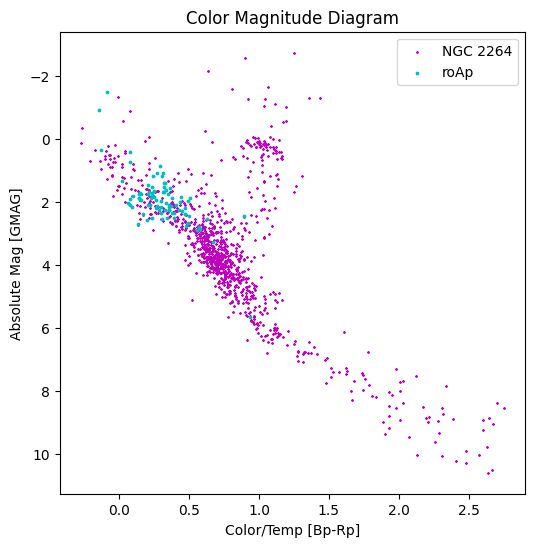

In [9]:
fig, ax = plt.subplots(1,figsize=(6,6))

plt.scatter(x=xc,y=yc,marker='*',c='m',label='NGC 2264',s=1)
plt.scatter(x=xr,y=yr,c='c',label='roAp',s=3)

plt.gca().invert_yaxis()

plt.title('Color Magnitude Diagram')
plt.ylabel('Absolute Mag [GMAG]')
plt.xlabel('Color/Temp [Bp-Rp]')
plt.legend(loc='best')
plt.savefig('Data/CMD with Error Ellipses')
plt.show()

#### Plotting single Error ellipse to show concept

In [10]:
# Making the Ellipse Equation
sigma = []
a = sig_gme*(np.sin(theta))
b = sig_bp_rp_e*(np.cos(theta))
avg_a = np.mean(a, axis=0)
avg_b = np.mean(b, axis=0)
avg_a = (np.array([avg_a])).transpose()
avg_b = (np.array([avg_b])).transpose()
for i in range(len(xc)):
    sigma.append({'Height(a)':avg_a[i],'Width(b)':avg_b[i]})
dfs = pd.DataFrame(sigma)
dfs.head(n=15)

,Height(a),Width(b)
0,[0.004422242271697634],[0.014037660959230676]
1,[0.00862520351549884],[0.0008663139536050641]
2,[0.003967317313898273],[0.0036101064474005416]
3,[0.004374312833929549],[0.006984070521160444]
4,[0.003643664523136009],[0.0012266455888967928]
5,[0.003016202787995065],[0.0015252474960876262]
6,[0.0021715179646141524],[0.0023462598558645575]
7,[0.003907916827923291],[0.0002340192586726312]
8,[0.003972696474762173],[0.035639211771691]
9,[0.004002061861818168],[0.0065932240405343605]


<Axes.ArtistList of 1 patches>


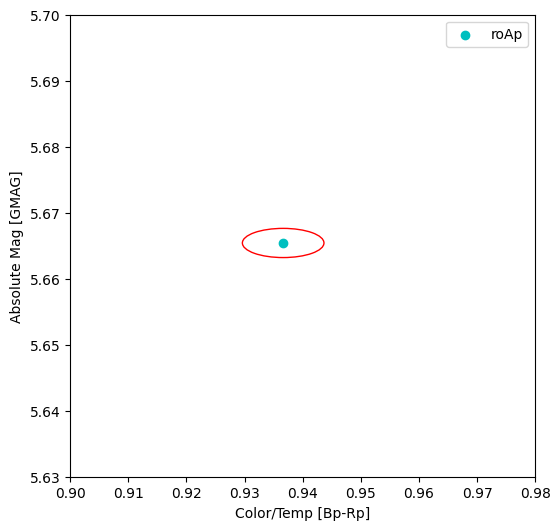

In [11]:
a0 = (dfs['Height(a)'][0])
b0 = (dfs['Width(b)'][0])
xr0 = (roAp['BP-RP0'])[0]
yr0 = (roAp['GMAG0'])[0]

fig, ax = plt.subplots(1,figsize=(6,6))

ellipse = mpatches.Ellipse(xy=(xr0,yr0),width=b0,height=a0)
ax.add_patch(ellipse)
ellipse.set_facecolor('None')
ellipse.set_edgecolor('r')
print(ax.patches)

plt.scatter(xr0,yr0,c='c',label='roAp')
plt.ylabel('Absolute Mag [GMAG]')
plt.xlabel('Color/Temp [Bp-Rp]')
plt.xlim(0.9,0.98)
plt.ylim(5.63,5.7)
plt.legend(loc='best')
plt.show()

#### Calculating all error ellipses with roAp and cluster sigmas

In [12]:
# Making a for loop to draw an ellipse around each roAp data point
ellipse0 = []
ellipse1 = []
ellipse2 = []
ellipse3 = []

ay = dfs['Height(a)']
bx = dfs['Width(b)']

ellipse0 = [mpatches.Ellipse(xy=((roAp['BP-RP0'])[p],(roAp['GMAG0'])[p]),width=(b)[p][i],height=(a)[p][i])
           for p in range(len(xr)) for i in range(len(xc))]
ellipse1 = [mpatches.Ellipse(xy=((roAp['BP-RP0'])[p],(roAp['GMAG0'])[p]),width=2*(b)[p][i],height=2*(a)[p][i])
           for p in range(len(xr)) for i in range(len(xc))]
ellipse2 = [mpatches.Ellipse(xy=((roAp['BP-RP0'])[p],(roAp['GMAG0'])[p]),width=3*(b)[p][i],height=3*(a)[p][i])
           for p in range(len(xr)) for i in range(len(xc))]
ellipse3 = [mpatches.Ellipse(xy=((np.mean((roAp['BP-RP0']))),(np.mean(roAp['GMAG0'])))
                             ,width=(min((roAp['BP-RP0']))+max(abs(roAp['BP-RP0']))),height=(min((roAp['GMAG0']))+max(abs(roAp['GMAG0']))))]

#### Plotting all data with error ellipses in FOV of roAps

In [13]:
fig, ax = plt.subplots(1,figsize=(6,6))

for e in ellipse2:
    ax.add_artist(e)
    e.set_facecolor(color='None')
    e.set_edgecolor('m')
e.set_label('3$\sigma$')
for e in ellipse1:
    ax.add_artist(e)
    e.set_facecolor(color='None')
    e.set_edgecolor('blue')
e.set_label('2$\sigma$')
for e in ellipse0:
    ax.add_artist(e)
    e.set_facecolor(color='None')
    e.set_edgecolor('r')
e.set_label('1$\sigma$')
for e in ellipse3:
    ax.add_artist(e)
    e.set_facecolor(color='None')
    e.set_edgecolor('brown')
e.set_label('Density Ellipse')

plt.scatter(x=xc,y=yc,marker='*',c='c',label='cluster array',s=1,zorder=2)
plt.scatter(x=xr,y=yr,c='black',label='roAp',s=3,zorder=3)

plt.gca().invert_yaxis()

plt.title('Color Magnitude Diagram FOV with Error Ellipses')
plt.ylabel('Absolute Mag [GMAG]')
plt.xlabel('Color/Temp [Bp-Rp]')
plt.grid(zorder=1)
plt.legend(loc='best')
plt.xlim(-.3,1.3)
plt.ylim(6,-3)
plt.savefig('Data/CMD with Error Ellipses')
plt.show()

"fig, ax = plt.subplots(1,figsize=(6,6))\n\nfor e in ellipse2:\n    ax.add_artist(e)\n    e.set_facecolor(color='None')\n    e.set_edgecolor('m')\ne.set_label('3$\\sigma$')\nfor e in ellipse1:\n    ax.add_artist(e)\n    e.set_facecolor(color='None')\n    e.set_edgecolor('blue')\ne.set_label('2$\\sigma$')\nfor e in ellipse0:\n    ax.add_artist(e)\n    e.set_facecolor(color='None')\n    e.set_edgecolor('r')\ne.set_label('1$\\sigma$')\nfor e in ellipse3:\n    ax.add_artist(e)\n    e.set_facecolor(color='None')\n    e.set_edgecolor('brown')\ne.set_label('Density Ellipse')\n\nplt.scatter(x=xc,y=yc,marker='*',c='c',label='cluster array',s=1,zorder=2)\nplt.scatter(x=xr,y=yr,c='black',label='roAp',s=3,zorder=3)\n\nplt.gca().invert_yaxis()\n\nplt.title('Color Magnitude Diagram FOV with Error Ellipses')\nplt.ylabel('Absolute Mag [GMAG]')\nplt.xlabel('Color/Temp [Bp-Rp]')\nplt.grid(zorder=1)\nplt.legend(loc='best')\nplt.xlim(-.3,1.3)\nplt.ylim(6,-3)\nplt.savefig('Data/CMD with Error Ellipses')\np

#### Transposing all data to fit into columns

In [14]:
gmcet = gmce.transpose()
bp_rp_cet = bp_rp_ce.transpose()
ayt = ay.transpose()
bxt = bx.transpose()
xct = (np.array([xc])).transpose()
yct = (np.array([yc])).transpose()
print(gmcet.shape, bp_rp_cet.shape,'&',xct.shape,yct.shape,'&',ayt.shape,bxt.shape,np.array([xc]).shape)
print(gmcet)

(961, 1) (961, 1) & (961, 1) (961, 1) & (961,) (961,) (1, 961)
[[0.003578]
 [0.009215]
 [0.003447]
 [0.003461]
 [0.00388 ]
 [0.002906]
 [0.002818]
 [0.002782]
 [0.003435]
 [0.002996]
 [0.002802]
 [0.002773]
 [0.003291]
 [0.002957]
 [0.002849]
 [0.003973]
 [0.002799]
 [0.003029]
 [0.002967]
 [0.00284 ]
 [0.003315]
 [0.006052]
 [0.005014]
 [0.002835]
 [0.004225]
 [0.004699]
 [0.003218]
 [0.00443 ]
 [0.003305]
 [0.003941]
 [0.003307]
 [0.003265]
 [0.003425]
 [0.002775]
 [0.003385]
 [0.003083]
 [0.003363]
 [0.003184]
 [0.002946]
 [0.003754]
 [0.002966]
 [0.00284 ]
 [0.003499]
 [0.005293]
 [0.003364]
 [0.004439]
 [0.003369]
 [0.00324 ]
 [0.003083]
 [0.004905]
 [0.002802]
 [0.003935]
 [0.003151]
 [0.004755]
 [0.003329]
 [0.004589]
 [0.002785]
 [0.002787]
 [0.003867]
 [0.002765]
 [0.003363]
 [0.00315 ]
 [0.002798]
 [0.003374]
 [0.00328 ]
 [0.002842]
 [0.00288 ]
 [0.003299]
 [0.003886]
 [0.003754]
 [0.003518]
 [0.00293 ]
 [0.002775]
 [0.004696]
 [0.003249]
 [0.003081]
 [0.003263]
 [0.003223]
 

In [45]:
# TRYING THIS INSTEAD 
xca = np.array([xc])
yca = np.array([yc])
xcti = np.tile((xca), (len(xr),1))
ycti = np.tile((yca), (len(xr),1))
print(ycti.shape, a.shape)
print((b[:]))

(87, 961) (87, 961)
[[0.01743642 0.00066358 0.00256391 ... 0.00053251 0.00026223 0.00050351]
 [0.01405299 0.00087534 0.00093079 ... 0.00020802 0.00073935 0.00041885]
 [0.01572123 0.00043163 0.00610891 ... 0.00031122 0.00117345 0.00016299]
 ...
 [0.01461019 0.00075755 0.00225733 ... 0.00028401 0.00089051 0.00032899]
 [0.01645603 0.00036733 0.00871804 ... 0.00037092 0.00161473 0.00015878]
 [0.01303416 0.0013416  0.00030279 ... 0.00015496 0.00053336 0.00070445]]


In [46]:
# R squared values for Cluster and roAp mag error
cands = []
'''r = [np.sqrt((a[k][l])**2+(b[k][l])**2)
      for k in range(len(xr)) for l in range(xc)]'''
#avgr = np.mean(r)
# Calculating the averages
avgx = np.mean(xr)
avgy = np.mean(yr)
# calculating the position vectors
for q in range(len(xc)):
    for i in range(len(xr)):
        if (np.logical_and((xcti[0][q]<b[i][q]),(ycti)[0][q]<a[i][q])).any():
            cand = clust.iloc[q]['id']
            cands.append({'ID':cand,'Designation':(clust['designation'])[q],'GMAG':(clust['GMAG0'])[q],'GMAG_Error':(gmcet)[q],
                        'BP-RP':(clust['BP-RP0'])[q],'BP-RP_Error':(bp_rp_cet)[q]})#'Averaged_Deviation':(abs(d[q]-avgr))
            
cands = pd.DataFrame(cands)
cands.head(n=len(cands))

,ID,Designation,GMAG,GMAG_Error,BP-RP,BP-RP_Error
0,788,Gaia DR3 3326930222089771520,-1.309222,[0.002815],-0.004798,[0.0025129999999999996]
1,788,Gaia DR3 3326930222089771520,-1.309222,[0.002815],-0.004798,[0.0025129999999999996]
2,788,Gaia DR3 3326930222089771520,-1.309222,[0.002815],-0.004798,[0.0025129999999999996]
3,788,Gaia DR3 3326930222089771520,-1.309222,[0.002815],-0.004798,[0.0025129999999999996]
4,788,Gaia DR3 3326930222089771520,-1.309222,[0.002815],-0.004798,[0.0025129999999999996]
...,...,...,...,...,...,...
169,945,Gaia DR3 3326934791934688896,-0.322537,[0.003166],-0.266250,[0.0012920000000000006]
170,945,Gaia DR3 3326934791934688896,-0.322537,[0.003166],-0.266250,[0.0012920000000000006]
171,945,Gaia DR3 3326934791934688896,-0.322537,[0.003166],-0.266250,[0.0012920000000000006]
172,945,Gaia DR3 3326934791934688896,-0.322537,[0.003166],-0.266250,[0.0012920000000000006]


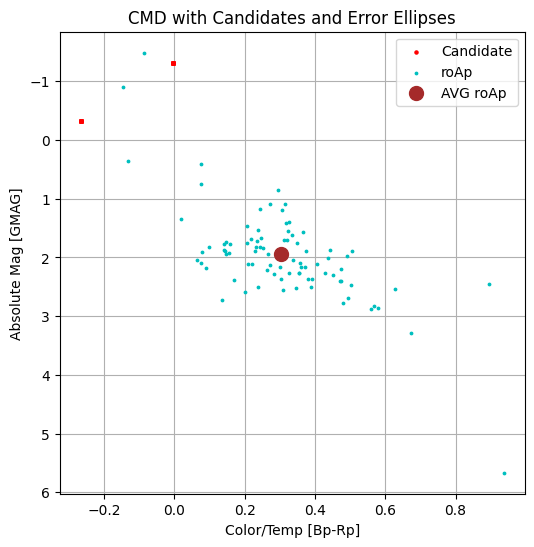

In [43]:
ub = cands['BP-RP']
ua = cands['GMAG']
fig, ax = plt.subplots(1,figsize=(6,6))

'''for e in ellipse2:
    ax.add_artist(e)
    e.set_facecolor(color='None')
    e.set_edgecolor('m')
e.set_label('3$\sigma$')
for e in ellipse1:
    ax.add_artist(e)
    e.set_facecolor(color='None')
    e.set_edgecolor('b')
e.set_label('2$\sigma$')
for e in ellipse0:
    ax.add_artist(e)
    e.set_facecolor(color='None')
    e.set_edgecolor('g')
e.set_label('1$\sigma$')'''

plt.scatter(ub,ua,c='red',label='Candidate',s=5,zorder=3)
plt.scatter(x=xr,y=yr,c='c',label='roAp',s=3,zorder=2)
plt.scatter(avgx,avgy,c='brown',s=100,label='AVG roAp',zorder=2)
plt.gca().invert_yaxis()

plt.title('CMD with Candidates and Error Ellipses')
plt.ylabel('Absolute Mag [GMAG]')
plt.xlabel('Color/Temp [Bp-Rp]')
plt.grid(zorder=1)
plt.legend(loc='best')
plt.savefig('Data/CMD with Cands')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_error_ellipse(data, error):
    """
    Plot error ellipse for a dataset.

    Parameters:
    - data: NxM array, the dataset
    - error: NxM array, the corresponding errors

    Returns:
    - None
    """

    # Calculate the covariance matrix
    cov_matrix = np.cov(data, rowvar=False)

    # Get the eigenvalues and eigenvectors of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

    # Get the angle of rotation from the eigenvectors
    angle = np.degrees(np.arctan2(eigenvectors[1, 0], eigenvectors[0, 0]))

    # Plot the data points
    plt.scatter(data[:, 0], data[:, 1], alpha=0.7, label='Data points')

    # Plot the error ellipse for each data point
    for i in range(len(data)):
        ellipse = plt.matplotlib.patches.Ellipse(data[i], 2 * np.sqrt(eigenvalues[0]) * error[i, 0],
                                                 2 * np.sqrt(eigenvalues[1]) * error[i, 1],
                                                 angle=angle, edgecolor='r', facecolor='none')
        plt.gca().add_patch(ellipse)

    plt.title('Error Ellipses')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage with random data and errors
np.random.seed(42)
mean = [np.mean(a), np.mean(b)]
covariance_matrix = [[2, 1], [1, 2]]
data = [[xr],[yr]]
error = np.vstack((a[0,:],b[0,:]))  # Replace with your actual error array

plot_error_ellipse(data, error)